<a href="https://colab.research.google.com/github/curyumafu/sakana/blob/main/%E7%94%BB%E5%83%8F%E5%88%86%E9%A1%9E_transfer(InceptionResNetV2)2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

セクション1: 必要なライブラリとモジュールのインポート

In [ ]:
from google.colab import drive, output
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from IPython.display import JSON as IPython_JSON
from PIL import Image, ImageFont, ImageDraw
import pickle
import cv2
import numpy as np
from io import BytesIO
import base64
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.preprocessing import image
import tensorflow as tf


セクション2: Google Drive のマウント

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/実験III_AI演習（ImageNet）2023


Mounted at /content/drive
/content/drive/MyDrive/実験III_AI演習（ImageNet）2023


セクション3: クラスラベルの読み込み

In [ ]:
# クラスラベルの読み込み
classes = pickle.load(open('classes.sav', 'rb'))

# クラスラベルをリストとして表示
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")


Class 0: ba
Class 1: de
Class 2: hai
Class 3: ka
Class 4: ka-do


セクション4: 画像にメッセージを追加する関数の定義

In [ ]:
def img_add_msg(img, message):
    """画像にメッセージを追加する関数"""
    font_path = 'ipaexg.ttf'
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)  # フォントの定義
    draw = ImageDraw.Draw(img)  # 描画用のDraw関数
    draw.text((0, 30), message, font=font, fill=(255, 255, 255, 0))  # テキストを描画
    return img


セクション5: モデルの読み込み

In [ ]:
# モデルの読み込み (SavedModel 形式)
model = tf.keras.models.load_model('./cnn_saved_model')

セクション6: 画像処理と予測を行う関数の定義

In [ ]:
def run(img_str):
    """画像処理と予測を行う関数"""
    # 画像のデコード
    decimg = base64.b64decode(img_str.split(',')[1], validate=True)
    decimg = Image.open(BytesIO(decimg))
    decimg = np.array(decimg, dtype=np.uint8)
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

    # 画像のトリミングと前処理
    trim_frame = decimg[:299, :299]
    x = image.img_to_array(trim_frame)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # 予測
    preds = model.predict(x, verbose=0)
    prelabel = np.argmax(preds, axis=1)[0]
    message = f"{classes[prelabel]} {preds[0][prelabel]*100:.2f}%"

    # 画像にメッセージを追加
    img = Image.fromarray(trim_frame)
    img = img_add_msg(img, message)
    img = np.array(img)

    # 画像をエンコードして送信
    _, encimg = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
    img_str = encimg.tobytes()
    img_str = "data:image/jpeg;base64," + base64.b64encode(img_str).decode('utf-8')
    return IPython_JSON({'img_str': img_str})

# コールバックの登録
output.register_callback('notebook.run', run)


セクション7: ウェブカメラの使用

In [ ]:
from google.colab.output import eval_js

def use_cam(quality=0.8):
    """ウェブカメラを使用して画像を取得し、処理を行う関数"""
    js = Javascript('''
    async function useCam(quality) {
      const div = document.createElement('div');
      document.body.appendChild(div);
      //video element
      const video = document.createElement('video');
      video.style.display = 'None';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      //canvas for display. frame rate is depending on display size and jpeg quality.
      display_size = 299
      const src_canvas = document.createElement('canvas');
      src_canvas.width  = display_size;
      src_canvas.height = display_size;;
      const src_canvasCtx = src_canvas.getContext('2d');
      src_canvasCtx.translate(src_canvas.width, 0);
      src_canvasCtx.scale(-1, 1);
      div.appendChild(src_canvas);

      const dst_canvas = document.createElement('canvas');
      dst_canvas.width  = src_canvas.width;
      dst_canvas.height = src_canvas.height;
      const dst_canvasCtx = dst_canvas.getContext('2d');
      div.appendChild(dst_canvas);

      //exit button
      const btn_div = document.createElement('div');
      document.body.appendChild(btn_div);
      const exit_btn = document.createElement('button');
      exit_btn.textContent = 'Exit';
      var exit_flg = true
      exit_btn.onclick = function() {exit_flg = false};
      btn_div.appendChild(exit_btn);

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      var send_num = 0
      // loop
      _canvasUpdate();
      async function _canvasUpdate() {
            src_canvasCtx.drawImage(video, 0, 0, video.videoWidth, video.videoHeight, 0, 0, src_canvas.width, src_canvas.height);
            if (send_num<1){
                send_num += 1
                const img = src_canvas.toDataURL('image/jpeg', quality);
                const result = google.colab.kernel.invokeFunction('notebook.run', [img], {});
                result.then(function(value) {
                    parse = JSON.parse(JSON.stringify(value))["data"]
                    parse = JSON.parse(JSON.stringify(parse))["application/json"]
                    parse = JSON.parse(JSON.stringify(parse))["img_str"]
                    var image = new Image()
                    image.src = parse;
                    image.onload = function(){dst_canvasCtx.drawImage(image, 0, 0)}
                    send_num -= 1
                })
            }
            if (exit_flg){
                requestAnimationFrame(_canvasUpdate);
            }else{
                stream.getVideoTracks()[0].stop();
            }
      };
    }
    ''')
    display(js)
    eval_js('useCam({})'.format(quality))

# ウェブカメラの使用を開始
use_cam()



<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive, output
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, HTML
from IPython.display import JSON as IPython_JSON
from PIL import Image, ImageFont, ImageDraw
import pickle
import cv2
import numpy as np
from io import BytesIO
import base64
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.preprocessing import image
import tensorflow as tf

drive.mount('/content/drive')
%cd /content/drive/MyDrive/実験III_AI演習（ImageNet）2023

# クラスラベルの読み込み
classes = pickle.load(open('classes.sav', 'rb'))

# クラスラベルをリストとして表示
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")

def img_add_msg(img, message):
    """画像にメッセージを追加する関数"""
    font_path = 'ipaexg.ttf'
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)  # フォントの定義
    draw = ImageDraw.Draw(img)  # 描画用のDraw関数
    draw.text((0, 30), message, font=font, fill=(255, 255, 255, 0))  # テキストを描画
    return img

# モデルの読み込み (SavedModel 形式)
model = tf.keras.models.load_model('./cnn_saved_model')

def get_comment_for_class(class_label):
    # ここで各クラスに対応したコメントを返すように実装してください
    # 例: クラス 'cat' に対応したコメント
    if class_label == 'アカザ':
        return "これは１０月に釣れる魚です"
    # 例: クラス 'dog' に対応したコメント
    elif class_label == 'アユ':
        return "これは1で釣れます"
    # ... (Add comments for other classes)
    else:
        return "No specific comment for this class yet."

def run(img_str):
    """画像処理と予測を行う関数"""
    # 画像のデコード
    decimg = base64.b64decode(img_str.split(',')[1], validate=True)
    decimg = Image.open(BytesIO(decimg))
    decimg = np.array(decimg, dtype=np.uint8)
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

    # 画像のトリミングと前処理
    trim_frame = decimg[:299, :299]
    x = image.img_to_array(trim_frame)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # 予測
    preds = model.predict(x, verbose=0)
    prelabel = np.argmax(preds, axis=1)[0]
    class_label = classes[prelabel]
    print(class_label)
    confidence = preds[0][prelabel] * 100
    message = f"{class_label} {confidence:.2f}%"

    # クラスに対応したコメントを取得
    comment = get_comment_for_class(class_label)

    # 画像にメッセージとコメントを追加
    img = Image.fromarray(trim_frame)
    img = img_add_msg(img, f"{message}\n{comment}")
    img = np.array(img)

    # 画像をエンコードして送信
    _, encimg = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
    img_str = encimg.tobytes()
    img_str = "data:image/jpeg;base64," + base64.b64encode(img_str).decode('utf-8')
    return IPython_JSON({'img_str': img_str})

# コールバックの登録
output.register_callback('notebook.run', run)

def use_cam(quality=0.8):
    button_html = """
    <script>
    async function startStopButton() {
      const div = document.createElement('div');
      const startBtn = document.createElement('button');
      startBtn.textContent = 'Start';
      const stopBtn = document.createElement('button');
      stopBtn.textContent = 'Stop';
      div.appendChild(startBtn);
      div.appendChild(stopBtn);
      document.body.appendChild(div);

      let exitFlg = true;
      let sendNum = 0;

      startBtn.onclick = async function() {
        exitFlg = true;
        startBtn.disabled = true;
        stopBtn.disabled = false;

        while (exitFlg) {
          // Your existing code to capture and process the webcam stream
          // ...

          if (sendNum < 1) {
            sendNum += 1;
            // Your existing code to invoke the function and update the canvas
            // ...
            sendNum -= 1;
          }

          // Your existing code to request the next frame
          // ...

          await new Promise(resolve => requestAnimationFrame(resolve));
        }
      };

      stopBtn.onclick = function() {
        exitFlg = false;
        startBtn.disabled = false;
        stopBtn.disabled = true;
      };
    }

    startStopButton();
    </script>
    """
    display(HTML(button_html))
    eval_js('startStopButton({})'.format(quality))

# ウェブカメラの使用を開始
use_cam()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/実験III_AI演習（ImageNet）2023
Class 0: ba
Class 1: de
Class 2: hai
Class 3: ka
Class 4: ka-do


In [ ]:
from google.colab import drive, output
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from IPython.display import JSON as IPython_JSON
from PIL import Image, ImageFont, ImageDraw
import pickle
import cv2
import numpy as np
from io import BytesIO
import base64
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.preprocessing import image
import tensorflow as tf



drive.mount('/content/drive')
%cd /content/drive/MyDrive/実験III_AI演習（ImageNet）2023



# クラスラベルの読み込み
classes = pickle.load(open('classes.sav', 'rb'))



# クラスラベルをリストとして表示
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")



def img_add_msg(img, message):
    """画像にメッセージを追加する関数"""
    font_path = 'ipaexg.ttf'
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)  # フォントの定義
    draw = ImageDraw.Draw(img)  # 描画用のDraw関数
    draw.text((0, 30), message, font=font, fill=(255, 255, 255, 0))  # テキストを描画
    return img



# モデルの読み込み (SavedModel 形式)
model = tf.keras.models.load_model('./cnn_saved_model')



# コメントを返す関数（クラスごとに変更が必要です）
def get_comment_for_class(class_label):
    # ここで各クラスに対応したコメントを返すように実装してください
    # 例: クラス 'cat' に対応したコメント
    if class_label == 'アカザ':
        return "これは１０月に釣れる魚です"
    # 例: クラス 'dog' に対応したコメント
    elif class_label == 'アユ':
        return "これは1で釣れます"
    elif class_label == 'ウナギ':
        return "これは2で釣れます"
    elif class_label == 'カジカ':
        return "これは3で釣れます"
    elif class_label == 'コイ':
        return "これは4で釣れます"
    elif class_label == 'サケ':
        return "これは5で釣れます"
    elif class_label == 'サンフィッシュ':
        return "これは6で釣れます"
    elif class_label == 'ドジョウ':
        return "これは7で釣れます"
    elif class_label == 'ナマズ':
        return "これは8で釣れます"
    elif class_label == 'ハゼ':
        return "これは9で釣れます"
    elif class_label == '背景':
        return "これは背景です"
    else:
        return "No specific comment for this class yet."



def run(img_str):
    """画像処理と予測を行う関数"""
    # 画像のデコード
    decimg = base64.b64decode(img_str.split(',')[1], validate=True)
    decimg = Image.open(BytesIO(decimg))
    decimg = np.array(decimg, dtype=np.uint8)
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

    # 画像のトリミングと前処理
    trim_frame = decimg[:299, :299]
    x = image.img_to_array(trim_frame)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # 予測
    preds = model.predict(x, verbose=0)
    prelabel = np.argmax(preds, axis=1)[0]
    class_label = classes[prelabel]
    print(class_label)
    confidence = preds[0][prelabel] * 100

    if confidence > 60:
        # If confidence is above 60%, stop processing and display message
        comment = get_comment_for_class(class_label)
        print(f"{class_label} {confidence:.2f}%")
        print(comment)
        return IPython_JSON({'img_str': None})

    # Continue processing if confidence is below 60%
    message = f"{class_label} {confidence:.2f}%"

    # クラスに対応したコメントを取得
    comment = get_comment_for_class(class_label)

    # 画像にメッセージとコメントを追加
    img = Image.fromarray(trim_frame)
    img = img_add_msg(img, f"{message}\n{comment}")
    img = np.array(img)

    # 画像をエンコードして送信
    _, encimg = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
    img_str = encimg.tobytes()
    img_str = "data:image/jpeg;base64," + base64.b64encode(img_str).decode('utf-8')
    return IPython_JSON({'img_str': img_str})




# コールバックの登録
output.register_callback('notebook.run', run)



from google.colab.output import eval_js



def use_cam(quality=0.8):
    """ウェブカメラを使用して画像を取得し、処理を行う関数"""
    js = Javascript('''
    async function useCam(quality) {
      const div = document.createElement('div');
      document.body.appendChild(div);
      //video element
      const video = document.createElement('video');
      video.style.display = 'None';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      //canvas for display. frame rate is depending on display size and jpeg quality.
      display_size = 299
      const src_canvas = document.createElement('canvas');
      src_canvas.width  = display_size;
      src_canvas.height = display_size;;
      const src_canvasCtx = src_canvas.getContext('2d');
      src_canvasCtx.translate(src_canvas.width, 0);
      src_canvasCtx.scale(-1, 1);
      div.appendChild(src_canvas);

      const dst_canvas = document.createElement('canvas');
      dst_canvas.width  = src_canvas.width;
      dst_canvas.height = src_canvas.height;
      const dst_canvasCtx = dst_canvas.getContext('2d');
      div.appendChild(dst_canvas);

      //exit button
      const btn_div = document.createElement('div');
      document.body.appendChild(btn_div);
      const exit_btn = document.createElement('button');
      exit_btn.textContent = 'Exit';
      var exit_flg = true
      exit_btn.onclick = function() {exit_flg = false};
      btn_div.appendChild(exit_btn);

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      var send_num = 0
      // loop
      _canvasUpdate();
      async function _canvasUpdate() {
            src_canvasCtx.drawImage(video, 0, 0, video.videoWidth, video.videoHeight, 0, 0, src_canvas.width, src_canvas.height);
            if (send_num<1){
                send_num += 1
                const img = src_canvas.toDataURL('image/jpeg', quality);
                const result = google.colab.kernel.invokeFunction('notebook.run', [img], {});
                result.then(function(value) {
                    parse = JSON.parse(JSON.stringify(value))["data"]
                    parse = JSON.parse(JSON.stringify(parse))["application/json"]
                    parse = JSON.parse(JSON.stringify(parse))["img_str"]
                    var image = new Image()
                    image.src = parse;
                    image.onload = function(){dst_canvasCtx.drawImage(image, 0, 0)}
                    send_num -= 1
                })
            }
            if (exit_flg){
                requestAnimationFrame(_canvasUpdate);
            }else{
                stream.getVideoTracks()[0].stop();
            }
      };
    }
    ''')
    display(js)
    eval_js('useCam({})'.format(quality))

# ウェブカメラの使用を開始
use_cam()




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/実験III_AI演習（ImageNet）2023
Class 0: ba
Class 1: de
Class 2: hai
Class 3: ka
Class 4: ka-do


KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive, output
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from IPython.display import JSON as IPython_JSON
from PIL import Image, ImageFont, ImageDraw
import pickle
import cv2
import numpy as np
from io import BytesIO
import base64
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.preprocessing import image
import tensorflow as tf


drive.mount('/content/drive')
%cd /content/drive/MyDrive/実験III_AI演習（ImageNet）2023

# クラスラベルの読み込み
classes = pickle.load(open('classes.sav', 'rb'))

# クラスラベルをリストとして表示
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")

def img_add_msg(img, message):
    """画像にメッセージを追加する関数"""
    font_path = 'ipaexg.ttf'
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)  # フォントの定義
    draw = ImageDraw.Draw(img)  # 描画用のDraw関数
    draw.text((0, 30), message, font=font, fill=(255, 255, 255, 0))  # テキストを描画
    return img

# モデルの読み込み (SavedModel 形式)
model = tf.keras.models.load_model('./cnn_saved_model')

def get_comment_for_class(class_label):
    # ここで各クラスに対応したコメントを返すように実装してください
    # 例: クラス 'cat' に対応したコメント
    if class_label == 'アカザ':
        return "これは１０月に釣れる魚です"
    # 例: クラス 'dog' に対応したコメント
    elif class_label == 'アユ':
        return "これは1で釣れます"
    elif class_label == 'ウナギ':
        return "これは2で釣れます"
    elif class_label == 'カジカ':
        return "これは3で釣れます"
    elif class_label == 'コイ':
        return "これは4で釣れます"
    elif class_label == 'サケ':
        return "これは5で釣れます"
    elif class_label == 'サンフィッシュ':
        return "これは6で釣れます"
    elif class_label == 'ドジョウ':
        return "これは7で釣れます"
    elif class_label == 'ナマズ':
        return "これは8で釣れます"
    elif class_label == 'ハゼ':
        return "これは9で釣れます"
    elif class_label == '背景':
        return "これは背景です"
    else:
        return "No specific comment for this class yet."

def run(img_str):
    """画像処理と予測を行う関数"""
    # 画像のデコード
    decimg = base64.b64decode(img_str.split(',')[1], validate=True)
    decimg = Image.open(BytesIO(decimg))
    decimg = np.array(decimg, dtype=np.uint8)
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

    # 画像のトリミングと前処理
    trim_frame = decimg[:299, :299]
    x = image.img_to_array(trim_frame)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # 予測
    preds = model.predict(x, verbose=0)
    prelabel = np.argmax(preds, axis=1)[0]
    class_label = classes[prelabel]
    print(class_label)
    confidence = preds[0][prelabel] * 100

    if confidence > 60:
        # If confidence is above 60%, stop processing and display message
        comment = get_comment_for_class(class_label)
        print(f"{class_label} {confidence:.2f}%")
        print(comment)
        return IPython_JSON({'img_str': None})

    # Continue processing if confidence is below 60%
    message = f"{class_label} {confidence:.2f}%"

    # クラスに対応したコメントを取得
    comment = get_comment_for_class(class_label)

    # 画像にメッセージとコメントを追加
    img = Image.fromarray(trim_frame)
    img = img_add_msg(img, f"{message}\n{comment}")
    img = np.array(img)

    # 画像をエンコードして送信
    _, encimg = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
    img_str = encimg.tobytes()
    img_str = "data:image/jpeg;base64," + base64.b64encode(img_str).decode('utf-8')
    return IPython_JSON({'img_str': img_str})

    # コールバックの登録
output.register_callback('notebook.run', run)



from google.colab.output import eval_js



def use_cam(quality=0.8):
    """ウェブカメラを使用して画像を取得し、処理を行う関数"""
    js = Javascript('''
    async function useCam(quality) {
      const div = document.createElement('div');
      document.body.appendChild(div);
      //video element
      const video = document.createElement('video');
      video.style.display = 'None';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      //canvas for display. frame rate is depending on display size and jpeg quality.
      display_size = 299
      const src_canvas = document.createElement('canvas');
      src_canvas.width  = display_size;
      src_canvas.height = display_size;;
      const src_canvasCtx = src_canvas.getContext('2d');
      src_canvasCtx.translate(src_canvas.width, 0);
      src_canvasCtx.scale(-1, 1);
      div.appendChild(src_canvas);

      const dst_canvas = document.createElement('canvas');
      dst_canvas.width  = src_canvas.width;
      dst_canvas.height = src_canvas.height;
      const dst_canvasCtx = dst_canvas.getContext('2d');
      div.appendChild(dst_canvas);

      //exit button
      const btn_div = document.createElement('div');
      document.body.appendChild(btn_div);
      const exit_btn = document.createElement('button');
      exit_btn.textContent = 'Exit';
      var exit_flg = true
      exit_btn.onclick = function() {exit_flg = false};
      btn_div.appendChild(exit_btn);

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      var send_num = 0
      // loop
      _canvasUpdate();
      async function _canvasUpdate() {
            src_canvasCtx.drawImage(video, 0, 0, video.videoWidth, video.videoHeight, 0, 0, src_canvas.width, src_canvas.height);
            if (send_num<1){
                send_num += 1
                const img = src_canvas.toDataURL('image/jpeg', quality);
                const result = google.colab.kernel.invokeFunction('notebook.run', [img], {});
                result.then(function(value) {
                    parse = JSON.parse(JSON.stringify(value))["data"]
                    parse = JSON.parse(JSON.stringify(parse))["application/json"]
                    parse = JSON.parse(JSON.stringify(parse))["img_str"]
                    var image = new Image()
                    image.src = parse;
                    image.onload = function(){dst_canvasCtx.drawImage(image, 0, 0)}
                    send_num -= 1
                })
            }
            if (exit_flg){
                requestAnimationFrame(_canvasUpdate);
            }else{
                stream.getVideoTracks()[0].stop();
            }
      };
    }
    ''')
    display(js)
    eval_js('useCam({})'.format(quality))

# ウェブカメラの使用を開始
use_cam()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/実験III_AI演習（ImageNet）2023
Class 0: ba
Class 1: de
Class 2: hai
Class 3: ka
Class 4: ka-do


<IPython.core.display.Javascript object>

ba
ba 87.12%
No specific comment for this class yet.
ka-do
ka-do 84.33%
No specific comment for this class yet.
ka-do
ka-do 83.90%
No specific comment for this class yet.
ka-do
ka-do 83.17%
No specific comment for this class yet.
ka-do
ka-do 70.89%
No specific comment for this class yet.
ka-do
ka-do 77.03%
No specific comment for this class yet.
ka-do
ka-do 74.18%
No specific comment for this class yet.
ka-do
ka-do 77.73%
No specific comment for this class yet.
ka-do
ka-do 88.83%
No specific comment for this class yet.
ka-do
ka-do 80.01%
No specific comment for this class yet.
ka-do
ka-do 81.65%
No specific comment for this class yet.
ka-do
ka-do 77.21%
No specific comment for this class yet.
ka-do
ka-do 84.40%
No specific comment for this class yet.
ka-do
ka-do
ka-do 85.09%
No specific comment for this class yet.
ba
ba
ba 73.14%
No specific comment for this class yet.
ba
ka-do


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/実験III_AI演習（ImageNet）2023
Class 0: ba
Class 1: de
Class 2: hai
Class 3: ka
Class 4: ka-do
ka-do


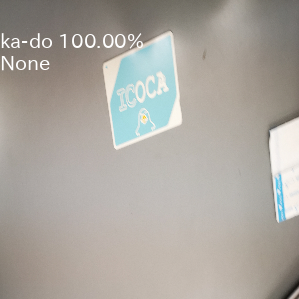

In [ ]:
from google.colab import drive, output
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from IPython.display import JSON as IPython_JSON
from PIL import Image, ImageFont, ImageDraw
import pickle
import cv2
import numpy as np
from io import BytesIO
import base64
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.preprocessing import image
import tensorflow as tf

drive.mount('/content/drive')
%cd /content/drive/MyDrive/実験III_AI演習（ImageNet）2023


# クラスラベルの読み込み
classes = pickle.load(open('classes.sav', 'rb'))

# クラスラベルをリストとして表示
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")

def img_add_msg(img, message):
    """画像にメッセージを追加する関数"""
    font_path = 'ipaexg.ttf'
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)  # フォントの定義
    draw = ImageDraw.Draw(img)  # 描画用のDraw関数
    draw.text((0, 30), message, font=font, fill=(255, 255, 255, 0))  # テキストを描画
    return img

# モデルの読み込み (SavedModel 形式)
model = tf.keras.models.load_model('./cnn_saved_model')

def get_comment_for_class(class_label):
    # ここで各クラスに対応したコメントを返すように実装してください
    # 例: クラス 'cat' に対応したコメント
    if class_label == 'アカザ':
        return "これは１０月に釣れる魚です"
    # 他のクラスに対応したコメントも追加

def process_image(file_path, quality=0.8):
    """Process an image from a file path."""
    # Read the image from the file path
    decimg = cv2.imread(file_path)

    # Check if the image is loaded successfully
    if decimg is None:
        print(f"Error: Unable to load the image from {file_path}")
        return None

    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

    # Resize the image to fit the model input size (299x299)
    decimg = cv2.resize(decimg, (299, 299))

    # Preprocess the image
    x = image.img_to_array(decimg)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Predict
    preds = model.predict(x, verbose=0)
    prelabel = np.argmax(preds, axis=1)[0]
    class_label = classes[prelabel]
    print(class_label)
    confidence = preds[0][prelabel] * 100
    message = f"{class_label} {confidence:.2f}%"

    # Get comment for the predicted class
    comment = get_comment_for_class(class_label)

    # Add message and comment to the image
    img = Image.fromarray(decimg)
    img = img_add_msg(img, f"{message}\n{comment}")
    decimg = np.array(img)

    # Return the processed image
    return Image.fromarray(decimg)

# Example usage:
file_path = '/content/drive/MyDrive/実験III_AI演習（ImageNet）2023/YT/IMG_20231107_141614.jpg '
result = process_image(file_path)

# Check if the result is not None before displaying
if result is not None:
    display(result)
else:
    print("Error processing the image.")


In [ ]:
from google.colab import drive, output
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from IPython.display import JSON as IPython_JSON
from PIL import Image, ImageFont, ImageDraw
import pickle
import cv2
import numpy as np
from io import BytesIO
import base64
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.preprocessing import image
import tensorflow as tf



drive.mount('/content/drive')
%cd /content/drive/MyDrive/実験III_AI演習（ImageNet）2023



# クラスラベルの読み込み
classes = pickle.load(open('classes.sav', 'rb'))



# クラスラベルをリストとして表示
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")



def img_add_msg(img, message):
    """画像にメッセージを追加する関数"""
    font_path = 'ipaexg.ttf'
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)  # フォントの定義
    draw = ImageDraw.Draw(img)  # 描画用のDraw関数
    draw.text((0, 30), message, font=font, fill=(255, 255, 255, 0))  # テキストを描画
    return img



# モデルの読み込み (SavedModel 形式)
model = tf.keras.models.load_model('./cnn_saved_model')



# コメントを返す関数（クラスごとに変更が必要です）
def get_comment_for_class(class_label):
    # ここで各クラスに対応したコメントを返すように実装してください
    # 例: クラス 'cat' に対応したコメント
    if class_label == 'アカザ':
        return "この魚はアカザという魚です。\n胸びれと背びれの部分に\n毒がある可能性があるため\n気をつけてください"
    # 例: クラス 'dog' に対応したコメント
    elif class_label == 'アユ':
        return "この魚はアユという魚です。\n毒は特にありません"
    elif class_label == 'ウナギ':
        return "この魚はウナギという魚です。\n体に毒はありませんが\n新鮮な血には毒があるため気を付けてください"
    elif class_label == 'カジカ':
        return "この魚はカジカという魚です。\n毒は特にありません"
    elif class_label == 'コイ':
        return "この魚はコイという魚です。\nコイの胆嚢にはコイ毒が含まれている\n可能性があるため調理する際は気をつけてください"
    elif class_label == 'サケ':
        return "この魚はサケという魚です。\n毒は特にありません"
    elif class_label == 'サンフィッシュ':
        return "この魚はサンフィッシュという魚です。\n毒は特にありません"
    elif class_label == 'ドジョウ':
        return "この魚はドジョウという魚です。\n毒は特にありません"
    elif class_label == 'ナマズ':
        return ""
    elif class_label == 'ハゼ':
        return "これは9で釣れます"
    elif class_label == '背景':
        return "これは背景です"
    else:
        return "No specific comment for this class yet."



def run(img_str):
    """画像処理と予測を行う関数"""
    # 画像のデコード
    decimg = base64.b64decode(img_str.split(',')[1], validate=True)
    decimg = Image.open(BytesIO(decimg))
    decimg = np.array(decimg, dtype=np.uint8)
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)



    # 画像のトリミングと前処理
    trim_frame = decimg[:299, :299]
    x = image.img_to_array(trim_frame)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)



    # 予測
    preds = model.predict(x, verbose=0)
    prelabel = np.argmax(preds, axis=1)[0]
    class_label = classes[prelabel]
    confidence = preds[0][prelabel] * 100
    message = f"{class_label} {confidence:.2f}%"



    # クラスに対応したコメントを取得
    comment = get_comment_for_class(class_label)



    # 画像にメッセージとコメントを追加
    img = Image.fromarray(trim_frame)
    img = img_add_msg(img, f"{message}\n{comment}")
    img = np.array(img)



    # 画像をエンコードして送信
    _, encimg = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
    img_str = encimg.tobytes()
    img_str = "data:image/jpeg;base64," + base64.b64encode(img_str).decode('utf-8')
    return IPython_JSON({'img_str': img_str})



# コールバックの登録
output.register_callback('notebook.run', run)



from google.colab.output import eval_js



def use_cam(quality=0.8):
    """ウェブカメラを使用して画像を取得し、処理を行う関数"""
    js = Javascript('''
    async function useCam(quality) {
      const div = document.createElement('div');
      document.body.appendChild(div);
      //video element
      const video = document.createElement('video');
      video.style.display = 'None';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      //canvas for display. frame rate is depending on display size and jpeg quality.
      display_size = 299
      const src_canvas = document.createElement('canvas');
      src_canvas.width  = display_size;
      src_canvas.height = display_size;;
      const src_canvasCtx = src_canvas.getContext('2d');
      src_canvasCtx.translate(src_canvas.width, 0);
      src_canvasCtx.scale(-1, 1);
      div.appendChild(src_canvas);

      const dst_canvas = document.createElement('canvas');
      dst_canvas.width  = src_canvas.width;
      dst_canvas.height = src_canvas.height;
      const dst_canvasCtx = dst_canvas.getContext('2d');
      div.appendChild(dst_canvas);

      //exit button
      const btn_div = document.createElement('div');
      document.body.appendChild(btn_div);
      const exit_btn = document.createElement('button');
      exit_btn.textContent = 'Exit';
      var exit_flg = true
      exit_btn.onclick = function() {exit_flg = false};
      btn_div.appendChild(exit_btn);

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      var send_num = 0
      // loop
      _canvasUpdate();
      async function _canvasUpdate() {
            src_canvasCtx.drawImage(video, 0, 0, video.videoWidth, video.videoHeight, 0, 0, src_canvas.width, src_canvas.height);
            if (send_num<1){
                send_num += 1
                const img = src_canvas.toDataURL('image/jpeg', quality);
                const result = google.colab.kernel.invokeFunction('notebook.run', [img], {});
                result.then(function(value) {
                    parse = JSON.parse(JSON.stringify(value))["data"]
                    parse = JSON.parse(JSON.stringify(parse))["application/json"]
                    parse = JSON.parse(JSON.stringify(parse))["img_str"]
                    var image = new Image()
                    image.src = parse;
                    image.onload = function(){dst_canvasCtx.drawImage(image, 0, 0)}
                    send_num -= 1
                })
            }
            if (exit_flg){
                requestAnimationFrame(_canvasUpdate);
            }else{
                stream.getVideoTracks()[0].stop();
            }
      };
    }
    ''')
    display(js)
    eval_js('useCam({})'.format(quality))

# ウェブカメラの使用を開始
use_cam()

In [ ]:
from google.colab import drive, output
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from IPython.display import JSON as IPython_JSON
from PIL import Image, ImageFont, ImageDraw
import pickle
import cv2
import numpy as np
from io import BytesIO
import base64
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.preprocessing import image
import tensorflow as tf

drive.mount('/content/drive')
%cd /content/drive/MyDrive/実験III_AI演習（ImageNet）2023


# クラスラベルの読み込み
classes = pickle.load(open('classes.sav', 'rb'))

# クラスラベルをリストとして表示
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")

def img_add_msg(img, message):
    """画像にメッセージを追加する関数"""
    font_path = 'ipaexg.ttf'
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)  # フォントの定義
    draw = ImageDraw.Draw(img)  # 描画用のDraw関数
    draw.text((0, 30), message, font=font, fill=(255, 255, 255, 0))  # テキストを描画
    return img

# モデルの読み込み (SavedModel 形式)
model = tf.keras.models.load_model('./cnn_saved_model')

# コメントを返す関数（クラスごとに変更が必要です）
def get_comment_for_class(class_label):
    # ここで各クラスに対応したコメントを返すように実装してください
    # 例: クラス 'cat' に対応したコメント
    if class_label == 'アカザ':
        return "この魚はアカザという魚です。\n胸びれと背びれの部分に\n毒がある可能性があるため\n気をつけてください"
    # 例: クラス 'dog' に対応したコメント
    elif class_label == 'アユ':
        return "この魚はアユという魚です。\n毒は特にありません"
    elif class_label == 'ウナギ':
        return "この魚はウナギという魚です。\n体に毒はありませんが\n新鮮な血には毒があるため気を付けてください"
    elif class_label == 'カジカ':
        return "この魚はカジカという魚です。\n毒は特にありません"
    elif class_label == 'コイ':
        return "この魚はコイという魚です。\nコイの胆嚢にはコイ毒が含まれている\n可能性があるため調理する際は気をつけてください"
    elif class_label == 'サケ':
        return "この魚はサケという魚です。\n毒は特にありません"
    elif class_label == 'サンフィッシュ':
        return "この魚はサンフィッシュという魚です。\n毒は特にありません"
    elif class_label == 'ドジョウ':
        return "この魚はドジョウという魚です。\n毒は特にありません"
    elif class_label == 'ナマズ':
        return ""
    elif class_label == 'ハゼ':
        return "これは9で釣れます"
    elif class_label == '背景':
        return "これは背景です"
    else:
        return "No specific comment for this class yet."

def get_comment_for_class(class_label):
    # ここで各クラスに対応したコメントを返すように実装してください
    # 例: クラス 'cat' に対応したコメント
    if class_label == 'アカザ':
        return "これは１０月に釣れる魚です"
    # 他のクラスに対応したコメントも追加

def process_image(file_path, quality=0.8):
    """Process an image from a file path."""
    # Read the image from the file path
    decimg = cv2.imread(file_path)

    # Check if the image is loaded successfully
    if decimg is None:
        print(f"Error: Unable to load the image from {file_path}")
        return None

    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

    # Resize the image to fit the model input size (299x299)
    decimg = cv2.resize(decimg, (299, 299))

    # Preprocess the image
    x = image.img_to_array(decimg)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Predict
    preds = model.predict(x, verbose=0)
    prelabel = np.argmax(preds, axis=1)[0]
    class_label = classes[prelabel]
    print(class_label)
    confidence = preds[0][prelabel] * 100
    message = f"{class_label} {confidence:.2f}%"

    # Get comment for the predicted class
    comment = get_comment_for_class(class_label)

    # Add message and comment to the image
    img = Image.fromarray(decimg)
    img = img_add_msg(img, f"{message}\n{comment}")
    decimg = np.array(img)

    # Return the processed image
    return Image.fromarray(decimg)

# Example usage:
file_path = '/content/drive/MyDrive/実験III_AI演習（ImageNet）2023/YT/IMG_20231107_141614.jpg '
result = process_image(file_path)

# Check if the result is not None before displaying
if result is not None:
    display(result)
else:
    print("Error processing the image.")

In [4]:
# dashのインストール
!pip install jupyter-dash==0.4.0

# dash_bootstrap_componentsインストール
!pip install dash_bootstrap_components==0.13.1

In [3]:
from jupyter_dash import JupyterDash
import dash_bootstrap_components as dbc

class JupyterDashBootStrap(JupyterDash):
  def __init__(self, _title, _port):
    super().__init__(__name__, external_stylesheets=self.__external_stylesheets())
    if _title is not None:
      self.title = _title
    self.__setlayout()
    self.__run(_port)

  def __setlayout(self):
      self.layout = self.buildbaselayout()
      self.registcalback(self)

  def buildbaselayout(self):
      return

  def registcalback(self, app):
      return

  def __run(self, _port):
    if _port is None:
      self.run_server(mode="external")
    else:
      self.run_server(mode="external", port=_port )

  def __external_stylesheets(self):
    return [dbc.themes.BOOTSTRAP]

ImportError: ignored